In [1]:
!which python

/opt/anaconda3/envs/hse_dl_task/bin/python


## `Задание 01. Сегментация изображений`

#### Фамилия, имя:

Дата выдачи: <span style="color:red">__05 марта 17:00__</span>.

Мягкий дедлайн: <span style="color:red">__26 марта 23:59__</span>.

<span style="color:red">__В ноутбуке все клетки должны выполняться без ошибок при последовательном их выполнении.__</span>

#### `Москва, 2024`

В этом задании вы будете решать задачу сегментации людей на фотографии с помощью нейросетевых архитектур `U-Net` и `LinkNet`.

Данные для выполнения задания можно скачать по [ссылке](https://disk.yandex.ru/d/tI6d3LBMHTwOnw).

## `Загрузка данных (1 балл)`

In [2]:
!ls

conda_start.sh	environment.yml   requirements.txt
data		jupiter_start.sh  task_01.ipynb


Для загрузки данных pytorch опирается на такую сущность, как **`Dataset`**.

Этот абстрактный класс определен в `torch.utils.data.dataset`:

```python
class Dataset(object):
    """An abstract class representing a Dataset.

    All other datasets should subclass it. All subclasses should override
    ``__len__``, that provides the size of the dataset, and ``__getitem__``,
    supporting integer indexing in range from 0 to len(self) exclusive.
    """

    def __getitem__(self, index):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

    def __add__(self, other):
        return ConcatDataset([self, other])
```
При определении нового источника данных мы создаем наследника данного класса и реализуем методы `__getitem__` и `__len__`.

Пример готового такого класса — `torchvision.datasets.ImageFolder`, который позволяет создать датасет на основе директории с ImageNet-подобной структурой поддиректорий (`./train/{class}` и `./val/{class}`):

```python
imagenet = torchvision.datasets.ImageFolder('path/to/imagenet_root/')
```

Реализуйте класс `PhotosDataset` для выданных данных.

**Внимание.** Возможно, стоит прочитать следующий пункт задания, чтобы реализация была удобной.

In [3]:
import os
import random

import numpy as np
import numpy.testing as npt

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.models import vgg13, VGG13_Weights
from torchvision import transforms
import torchvision

from PIL import Image, ImageEnhance

from tqdm.notebook import tqdm

import matplotlib_inline
import matplotlib.pyplot as plt

%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg')

In [65]:
class PhotosDataset(Dataset):
    def __init__(self, images_dir, target_dir=None, transforms=None):
        """
        Arguments
        ---------
        images_dir : str
            Path to directory with images

        target_dir : str
            Path to directory with masks.
            Each mask corresponds to one image.
            Corresponding mask and image have the same name, but different format.

        transforms : some collection
            Sequence of transformations for images and masks.
        """
        # your code here
        self.transforms = transforms if transforms else []
        self.masks_paths = None
        self.images_paths = sorted([os.path.join(images_dir, file_path) for file_path in os.listdir(images_dir) if file_path.endswith('.jpg')])
        if target_dir:
            self.masks_paths = sorted([os.path.join(target_dir, file_path) for file_path in os.listdir(target_dir) if file_path.endswith('.png')])


    def __len__(self):
        # your code here
        return len(self.images_paths)

    def __getitem__(self, idx):
        """
        Arguments
        ---------
        idx : int
            Index of image and mask

        Returns
        -------
        (image, mask)
        """
        # your code here
        img = Image.open(self.images_paths[idx])
        mask = None
        if self.masks_paths:
            mask = Image.open(self.masks_paths[idx])

        for transform in self.transforms:
            img, mask = transform(img, mask)

        return img, mask

In [66]:
train_ds = PhotosDataset(images_dir='/home/ZotovA/work/hsedl_segm_task/data/people_data/train', 
                         target_dir='/home/ZotovA/work/hsedl_segm_task/data/people_data/train_mask')

In [67]:
img, mask = train_ds[0]

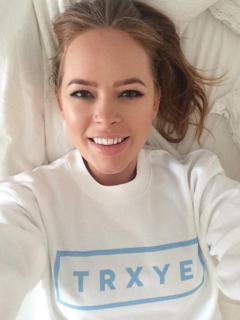

In [68]:
img

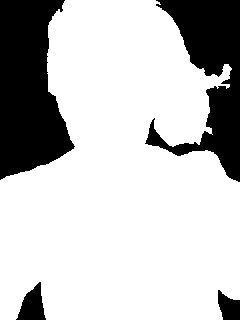

In [69]:
mask

In [70]:
len(train_ds)

1350

## `Модуль аугментации (2 балла)`

Конструктор стандартного `ImageFolder`, принимает параметр `transform` (и иногда `target_transform`).

Они служат для того, чтобы загружаемые изображения (обычно это `PIL.Image`) или таргеты преобразовывать в тензоры нужного вида.

В `torchvision` входит модуль `transforms` для стандартных примеров таких преобразований. В `transforms` могут содержаться случайные преобразования, это самый простой путь для реализации аугментации данных.

При определении кастомного трансформера помимо конструктора нужно реализовать лишь метод `__call__`:

```python
class HorizontalFlip(object):
    def __init__(self, mode=0):
        self.method = mode

    def __call__(self, img):
        """
        Args:
            img (PIL.Image): Image to be flipped.

        Returns:
            PIL.Image: Randomly flipped image.
        """
        if self.method:
            return img.transpose(Image.FLIP_LEFT_RIGHT)
        return img

```

С полным списком стандартных преобразований можно ознакомиться в [документации](https://pytorch.org/vision/0.12/transforms.html).

В данной части вам предлагается самостоятельно реализовать несколько кастомных трансформеров.
Обратите внимание, что для некоторых трансформеров, необходимо преобразовывать и изображение, и маску, а для каких-то только изображение.

Один из путей реализации:
* реализовать декоратор, делающий любое преобразование случайным
* реализовать декоратор, применяющий преобразование и к изображению, и к маске

Список трансформеров, которые надо реализовать:

* случайное (с вероятностью $p$) горизонтальное отображение (flip) изображения
* случайное (с вероятностью $p$) вырезание фрагмента изображения (заданного или случайного размера)
* случайное (с вероятностью $p$) изменение яркости изображения (на заданную или случайную величину)
* случайное (с вероятностью $p$) изменение фона изображения (на изображение из заданного списка изображений)

In [84]:
# your code here
class RandomHorizontalFlip(object):
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, img, mask):
        if random.random() < self.p:
            img = img.transpose(Image.FLIP_LEFT_RIGHT)
            mask = mask.transpose(Image.FLIP_LEFT_RIGHT)
        return img, mask

class RandomCutout(object):
    def __init__(self, size=None, p=0.5):
        self.p = p
        self.size = size

    def __call__(self, img, mask):
        if random.random() < self.p:
            width, height = img.size

            if self.size is None:
                # если размер патча не задан, то генерим случайный размер
                dx = random.randint(10, width // 2)
                dy = random.randint(10, height // 2)
            else:
                dx = self.size[0]
                dy = self.size[1]


            start_x = random.randint(0, width - dx)
            start_y = random.randint(0, height - dy)
            img.paste(0, (start_x, start_y, start_x + dx, start_y + dy))
            mask.paste(0, (start_x, start_y, start_x + dx, start_y + dy))

        return img, mask

class RandomBrightness(object):
    def __init__(self, factor=None, p=0.5):
        self.p = p
        self.factor = factor

    def __call__(self, img, mask):
        if random.random() < self.p:

            if self.factor is None:
                # если размер коэффициента не задан, то генерим случайный коэффициент в отрезке [0.5, 2.0]
                df = random.uniform(0.5, 2.0)
            else:
                df = self.factor

            enhancer = ImageEnhance.Brightness(img)
            img = enhancer.enhance(df)

        return img, mask

class CustToTensor(object):
    def __init__(self):
        self.to_tensor = transforms.ToTensor()

    def __call__(self, img, mask):
        return self.to_tensor(img), self.to_tensor(mask)

class CustNormalize(object):
    def __init__(self, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
        self.normalize = transforms.Normalize(mean=mean, std=std)


    def __call__(self, img, mask):
        return self.normalize(img), mask

In [86]:
class BgAugmenter(object):
    def __init__(self, images_dir, p=0.5):
        self.p = p
        self.paths = [os.path.join(images_dir, file_path) for file_path in os.listdir(images_dir) if file_path.endswith('.jpg')]
        self.length = len(self.paths)

    def __call__(self, img, mask):
        if random.random() < self.p:
            idx = random.randint(0, self.length-1)
            bg_img = Image.open(self.paths[idx])
            # msk = mask.convert("L")
            img = Image.composite(img, bg_img, mask)

        return img, mask

Добавьте случайные преобразования в ваши датасеты. Также, добавьте преобразование в tensor и нормализацию для изображения:

```python
transforms.ToTensor()
transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)
```

In [87]:
train_transforms = [
    BgAugmenter(images_dir='/home/ZotovA/work/hsedl_segm_task/data/lds_resized', p=0.5),
    # RandomBrightness(factor=1.5, p=0.5),
    RandomBrightness(p=0.5),
    # RandomCutout(size=(100, 100), p=0.5),
    RandomCutout(p=0.5),
    RandomHorizontalFlip(p=0.5),
    CustToTensor(),
    CustNormalize()
]

test_transforms = [
    CustToTensor(),
    CustNormalize()
]

In [88]:
DATA_PATH = '/home/ZotovA/work/hsedl_segm_task/data/people_data' # your path

train_dataset = PhotosDataset(
    images_dir=os.path.join(DATA_PATH, 'train'),
    target_dir=os.path.join(DATA_PATH, 'train_mask'),
    transforms=train_transforms # your code here
)

test_dataset = PhotosDataset(
    images_dir=os.path.join(DATA_PATH, 'test'),
    target_dir=os.path.join(DATA_PATH, 'test_mask'),
    transforms=test_transforms # your code here
)

Функция для отображения изображения:

In [89]:
def show_idx_image(dataset, idx):
    image, mask = dataset[idx]

    image = image.permute(1, 2, 0).numpy()
    image = (image * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
    image = np.clip(image, 0, 1)

    mask = mask.squeeze(0).numpy()
    # mask = (255 * mask).astype(int)
    fig, axes = plt.subplots(1, 2, figsize=(6, 4))

    axes[0].imshow(image)
    axes[1].imshow(mask)

    axes[0].set_axis_off()
    axes[1].set_axis_off()

    fig.tight_layout()
    plt.show()

Отобразите несколько изображений и масок, на которых будет видна правильная работа вашего модуля аугментации данных.

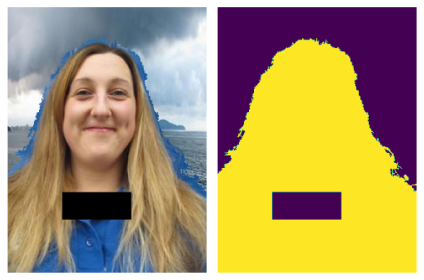

In [90]:
# your code here
show_idx_image(train_dataset, 42)

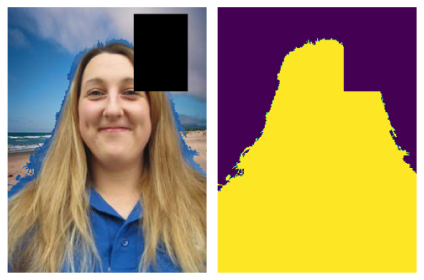

In [91]:
show_idx_image(train_dataset, 42)

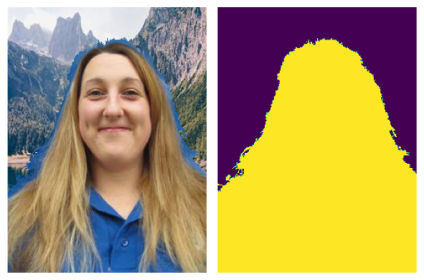

In [92]:
show_idx_image(train_dataset, 42)

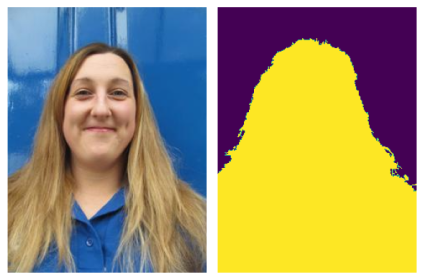

In [93]:
show_idx_image(train_dataset, 42)

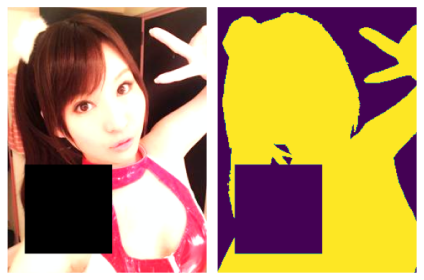

In [94]:
show_idx_image(train_dataset, 420)

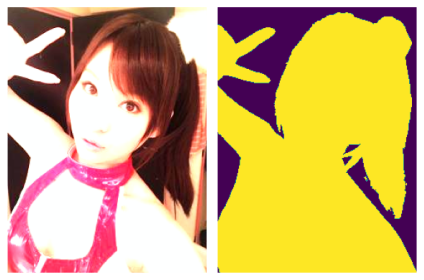

In [95]:
show_idx_image(train_dataset, 420)

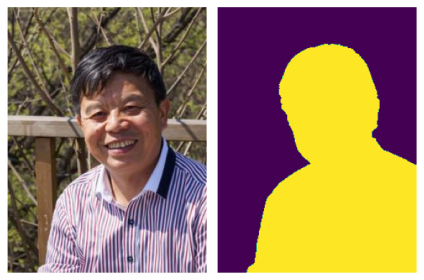

In [96]:
show_idx_image(test_dataset, 15)

## `Загрузчики`

При обучении сети удобнее работать не с датасетами, а с загрузчиками. Загрузчики создаются на основе датасета и позволяют итерироваться по батчам из него.

Обратите внимание на параметры `DataLoader`. При `num_workers`$\;> 1$, батчи готовятся (загружаются картинки, обрабатываются и так далее) сразу в нескольких фоновых процессах. С помощью параметра `shuffle` можно подавать картинки на обучение в случайном порядке.

Обычно, скорость обработки данных на GPU превышает скорость загрузки данных в одном процессе, поэтому типичное значение для `num_workers`$\approx 3\text{-}10$.

Учтите, что на некоторых системах в Jupyter Notebook при `num_workers`$>0$ `DataLoader` перестаёт работать. В таком случае установите это значение в $0$.

In [97]:
test_data_loader = DataLoader(test_dataset, batch_size=8, num_workers=2)
train_data_loader = DataLoader(train_dataset, batch_size=8, num_workers=2, shuffle=True)

## `DiceLoss (1 балл)`

Функция потерь реализовывается как и все стандартные нейронные модули в pytorch, через `torch.nn.Module`. В ячейке ниже вам предлагается реализовать функцию потерь `dice` (аналог меры Жаккарда).

Результат **Dice Loss** определим как:

$$
\text{Dice Coefficient} = 2\frac{|A \cap B| }{|A| + |B|} \leadsto \text{Dice Loss} = 1 - \frac{2\sum\limits_{i, j}a_{ij}b_{ij}}{\sum\limits_{ij}(a_{ij} + b_{ij} + \varepsilon)}
$$

где $a_{ij} \in [0, 1]$ — предсказанная вероятность нахождения человека в пикселе изображения, $b_{ij}$ — истинная разметка для пикселя изображения.

In [98]:
class DiceLoss(torch.nn.Module):
    def __init__(self, eps=1e-7, reduction=None, with_logits=True):
        """
        Arguments
        ---------
        eps : float
            eps in denominator
        reduction : Optional[str] (None, 'mean' or 'sum')
            specifies the reduction to apply to the output:

            None: no reduction will be applied
            'mean': the sum of the output will be divided by the number of elements in the batch
            'sum':  the output will be summed.
        with_logits : bool
            If True, use additional sigmoid for inputs
        """
        super().__init__()
        self.eps = eps
        self.reduction = reduction
        self.with_logits = with_logits

    def forward(self, logits, true_labels):
        """
        Arguments
        ---------
        logits: torch.Tensor
            Unnormalized probability of true class. Shape: [B, ...]
        true_labels: torch.Tensor
            Mask of correct predictions. Shape: [B, ...]
        Returns
        -------
        torch.Tensor
            If reduction is 'mean' or 'sum' returns a tensor with a single element
            Otherwise, returns a tensor of shape [B]
        """
        true_labels = true_labels.to(torch.long)

        if self.with_logits:
            # your code here
            logits = torch.sigmoid(logits)

        # your code here
        intersection = (logits * true_labels).sum(dim=(1, 2))
        union = logits.sum(dim=(1, 2)) + true_labels.sum(dim=(1, 2)) + self.eps

        dice = 2 * intersection / union
        loss_value = 1 - dice

        if self.reduction == 'sum':
            # your code here
            loss_value = loss_value.sum()
        elif self.reduction == 'mean':
            # your code here
            loss_value = loss_value.mean()


        return loss_value

Проверка реализации:

In [99]:
logits = torch.tensor([
    [[0, 0.5], [0.5, 1]],
    [[0.1, 0.1], [0, 0]],
])

target = torch.tensor([
    [[0, 1], [1, 1]],
    [[1, 0], [0, 1]],
])

losses = DiceLoss(with_logits=False, reduction=None, eps=1e-7)(logits, target)
npt.assert_almost_equal(losses.numpy(), np.array([0.2, 0.90909]), decimal=4)

loss = DiceLoss(with_logits=False, reduction='mean', eps=1e-7)(logits, target)
npt.assert_almost_equal(float(loss.numpy()), 0.554545, decimal=4)

loss = DiceLoss(with_logits=False, reduction='sum', eps=1e-7)(logits, target)
npt.assert_almost_equal(float(loss.numpy()), 1.10909, decimal=4)

## `U-Net (3 балла)`

Для решения задачи сегментации будем использовать [U-Net](https://arxiv.org/pdf/1505.04597.pdf) с энкодером из первых блоков предобученного `VGG13`.

Концептуальная схема представлена на диаграмме ниже:

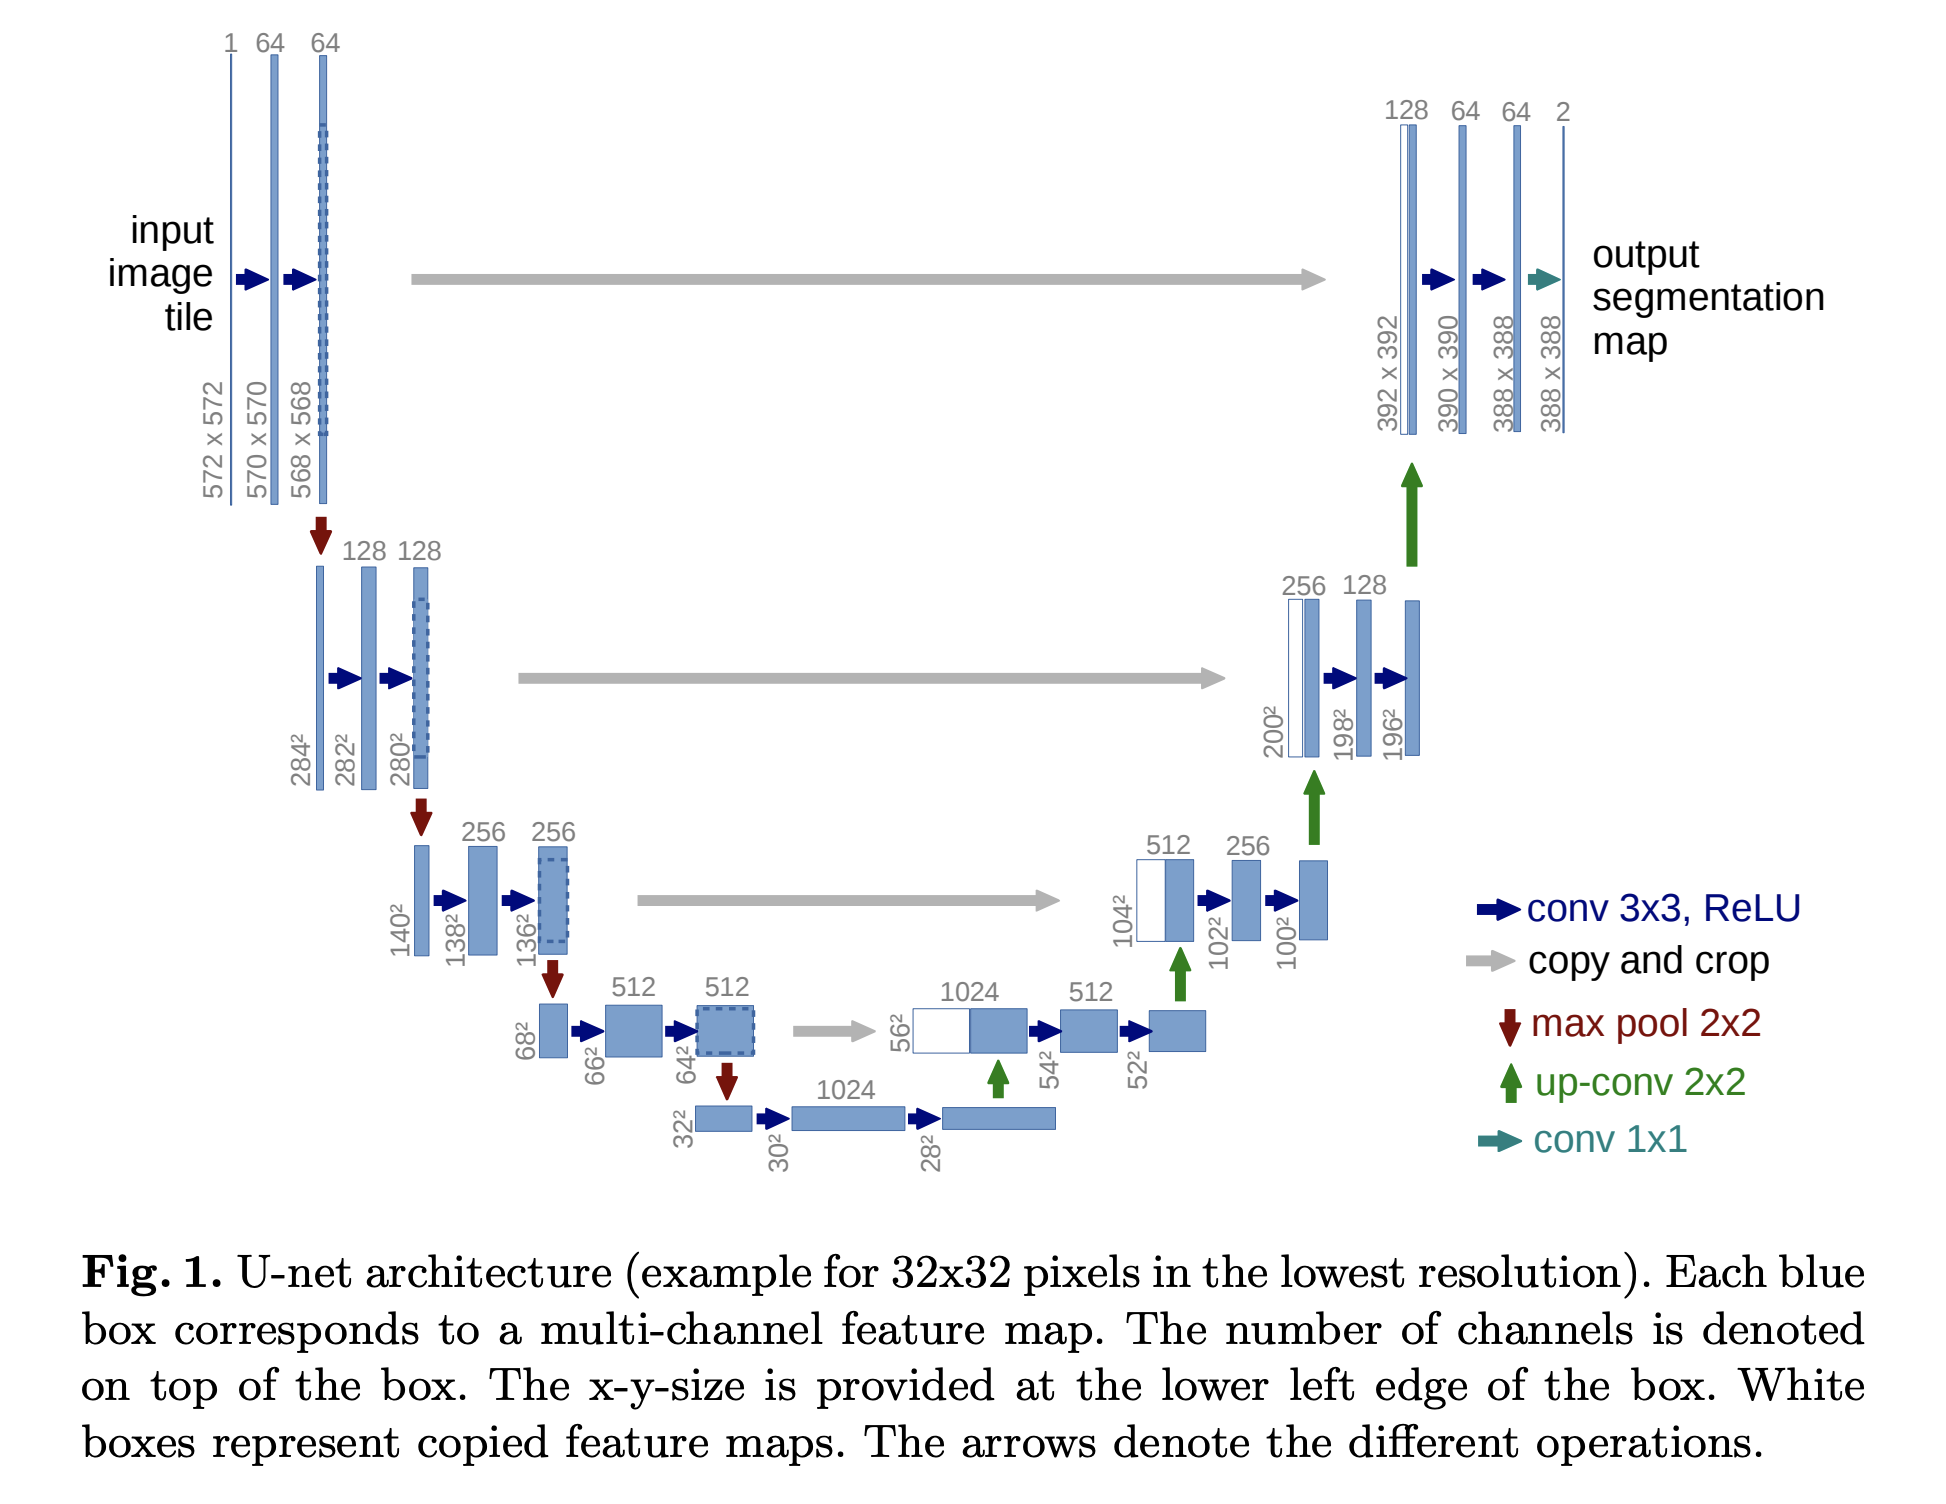

Заметим, что блоки VGG13 имеют следующий вид:
```python
    (0): Conv2d(...)
    (1): ReLU(...)
    (2): Conv2d(...)
    (3): ReLU(...)
    (4): MaxPool2d(...)
```

Для удобства, уберём слои `MaxPool2d` из блоков энкодера и будем применять pooling отдельно.

Реализуйте архитектуру данной сети.

#### `Encoder`

In [100]:
class VGG13Encoder(torch.nn.Module):
    def __init__(self, num_blocks, weights=VGG13_Weights.DEFAULT):
        super().__init__()
        self.num_blocks = num_blocks

        # Будем использовать предобученную VGG13 в качестве backbone
        feature_extractor = vgg13(weights=weights).features

        # Каждый блок энкодера U-Net — это блок VGG13 без MaxPool2d
        self.blocks = torch.nn.ModuleList()
        for idx in range(self.num_blocks):
            # Возьмите нужные слои из `feature_extractor` для очередного U-Net блока
            # Объедините их с помощью `torch.nn.Sequential`
            self.blocks.append(
                # your code here
                 torch.nn.Sequential(*[feature_extractor[i] for i in range(5*idx, 5*idx+4)])
            )

    def forward(self, x):
        activations = []
        for idx, block in enumerate(self.blocks):
            # Примените очередной блок U-Net
            # your code here
            x = block(x)

            # Сохраните активации для передачи их в декодер
            # your code here
            activations.append(x)

            # При необходимости примените max-pool
            # Можно использовать `torch.functional.F.max_pool2d`
            # your code here
            if idx != self.num_blocks - 1:  # не применяем max-pool после последнего блока
                x = torch.functional.F.max_pool2d(x, kernel_size=2, stride=2)

        return activations

In [101]:
assert sum((param.numel() for param in VGG13Encoder(num_blocks=1).parameters())) == 38720
assert sum((param.numel() for param in VGG13Encoder(num_blocks=2).parameters())) == 260160
assert sum((param.numel() for param in VGG13Encoder(num_blocks=3).parameters())) == 1145408

x = torch.arange(1 * 3 * 320 * 240).reshape(1, 3, 320, 240) / (1 * 3 * 320 * 240)
out = VGG13Encoder(num_blocks=3)(x)

assert len(out) == 3
npt.assert_almost_equal(torch.linalg.norm(out[0]).item(), 902.218, decimal=3)
npt.assert_almost_equal(torch.linalg.norm(out[1]).item(), 571.030, decimal=3)
npt.assert_almost_equal(torch.linalg.norm(out[2]).item(), 648.068, decimal=3)

#### `Decoder`

In [102]:
class DecoderBlock(torch.nn.Module):
    def __init__(self, out_channels):
        super().__init__()

        self.upconv = torch.nn.Conv2d(
            in_channels=out_channels * 2, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.conv1 = torch.nn.Conv2d(
            in_channels=out_channels * 2, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.conv2 = torch.nn.Conv2d(
            in_channels=out_channels, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.relu = torch.nn.ReLU()

    def forward(self, down, left):
        # Upsample x2 и свёртка
        # your code here
        x = torch.nn.Upsample(mode='bicubic' , scale_factor=2)(down)
        x = self.upconv(x)

        # Конкатенация выхода энкодера и предыдущего блока декодера
        # your code here
        x = torch.cat([left, x], dim=1)

        # Две свёртки с ReLu
        # your code here
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))

        return x

In [103]:
class Decoder(torch.nn.Module):
    def __init__(self, num_filters, num_blocks):
        super().__init__()

        self.blocks = torch.nn.ModuleList()
        for idx in range(num_blocks):
            self.blocks.insert(0, DecoderBlock(num_filters * 2 ** idx))

    def forward(self, acts):
        up = acts[-1]
        for block, left in zip(self.blocks, acts[-2::-1]):
            up = block(up, left)
        return up

#### `U-Net`

In [104]:
class UNet(torch.nn.Module):
    def __init__(self, num_classes=1, num_blocks=4):
        super().__init__()
        # your code here
        self.encoder = VGG13Encoder(num_blocks)

        # your code here
        self.decoder = Decoder(64, num_blocks-1)

        # Свёртка 1x1 для попиксельной агрегации каналов
        # your code here
        self.final = torch.nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        # your code here
        acts = self.encoder(x)
        x = self.decoder(acts)
        x = self.final(x)
        return x

In [105]:
model = UNet(num_classes=1, num_blocks=3)
x = torch.arange(1 * 3 * 320 * 240).reshape(1, 3, 320, 240) / (1 * 3 * 320 * 240)

assert sum((param.numel() for param in model.parameters())) == 2067649
assert list(model(x).shape) == [1, 1, 320, 240]
model

UNet(
  (encoder): VGG13Encoder(
    (blocks): ModuleList(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
      (1): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
      (2): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
    )
  )
  (decoder): Decoder(
    (blocks): ModuleList(
      (0): DecoderBlock(
        (upconv): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       

### `Оценивание качества сети`


Обычно, оптимизируемый функционал сложно интерпретировать, а так же в разных экспериментах могут использоваться разные функции потерь. Поэтому необходимо замерять и отслеживать независимую метрику качества. Предлагается использовать **IoU (Intersection over Union)** — один из стандартных вариантов для задачи сегментации:
$$
\text{IoU} = \frac{|A \cap B|}{|A \cup B|} = \frac{\sum\limits_{ij}a_{ij}b_{ij}}{\sum\limits_{ij}a_{ij} + b_{ij} - a_{ij}b_{ij}}
$$

In [106]:
class IoUScore(torch.nn.Module):
    def __init__(self, threshold, reduction=None):
        """
        Arguments
        ---------
        threshold : float
            threshold for logits binarization
        reduction : Optional[str] (None, 'mean' or 'sum')
            specifies the reduction to apply to the output:

            None: no reduction will be applied
            'mean': the sum of the output will be divided by the number of elements in the batch
            'sum':  the output will be summed.
        with_logits : bool
            If True, use additional sigmoid for inputs
        """
        super().__init__()

        self.threshold = threshold
        self.reduction = reduction

    @torch.no_grad()
    def forward(self, logits, true_labels):
        """
        Arguments
        ---------
        logits: torch.Tensor
            Unnormalized probability of true class. Shape: [B, ...]
        true_labels: torch.Tensor
            Mask of correct predictions. Shape: [B, ...]
        Returns
        -------
        torch.Tensor
            If reduction is 'mean' or 'sum' returns a tensor with a single element
            Otherwise, returns a tensor of shape [B]
        """
        # your code here
        dim = tuple(range(1, logits.dim()))
        logits = (logits > self.threshold).float()
        intersection = (logits * true_labels).sum(dim=dim)
        union = (logits + true_labels).sum(dim=dim) - intersection
        score = intersection / union

        if self.reduction == 'sum':
            # your code here
            score = score.sum()
        elif self.reduction == 'mean':
            # your code here
            score = score.mean()

        return score

In [107]:
logits = torch.tensor([
    [
        [0.3089,  0.4311, -0.9711],
        [0.9030,  1.0325, -0.7607],
        [0.9648, -0.5528, -1.1010]
    ], [
        [0.8906,  0.8099,  0.4458],
        [2.6215, -1.3198,  0.3142],
        [0.2262, -0.9175, -0.0174]
    ], [
        [0.8906,  0.8099,  0.4458],
        [2.6215, -1.3198,  0.3142],
        [0.2262, -0.9175, -0.0174]
    ]
])
true_labels = torch.tensor([
    [
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 0., 1.]
    ], [
        [1., 1., 1.],
        [1., 0., 1.],
        [1., 0., 0.]
    ], [
        [1., 1., 1.],
        [0., 1., 1.],
        [1., 1., 1.]
    ]
])

scores = IoUScore(0.0)(logits, true_labels)
npt.assert_almost_equal(scores.numpy(), np.array([0.3333, 1.0000, 0.5556]), decimal=4)

score = IoUScore(0.0, reduction='sum')(logits, true_labels)
npt.assert_almost_equal(score.item(), 1.8889, decimal=4)

score = IoUScore(0.0, reduction='mean')(logits, true_labels)
npt.assert_almost_equal(score.item(), 0.6296, decimal=4)

### `Tensorboard и логирование`

Для отслеживания процесса обучения обычно требуется сохранять информацию разных его аспектах.

Для полного контроля над процессом обучения обычно требуется сохранять информацию о разных статистиках. Самыми очевидными являются:
1. Значение функции потерь (лосса) на обучающей и тестовой выборках
2. Метики качества, например, **Dice Coefficient** и **IoU (Intersection over Union)** на обучающей и тестовой выборках

Однако, суррогатные метрики могут не отражать реального качества. Поэтому для моделей, которые выдают визуализируемый результат, обычно логируют предсказания для некоторых объектов выборки. В задаче сегментации естественным вариантом является логирование четвёрки: исходное изображение, истинная маска, маска вероятностей истинного класса, бинаризованная маска.

*Замечание:* лосс и качество на обучающей выборке обычно логируют не только в конце каждой эпохи, но и по отдельным батчам на каждой итерации.

3. Чтобы отслеживать динамику обучения необходимо зафиксировать небольшой набор объектов обучающей и тестовой выборок и после каждой эпохи обучения логировать указанные четыре картинки для каждого объекта.

*Замечание:* можно логировать четвёрки изображений независимо, однако, удобнее объединить их на одной [фигуре](https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.SummaryWriter.add_figure). Дополнительный плюс — возможность подписать значения метрик для этого объекта в заголовке изображения или добавить colorbar для более простой интерпретации предсказанной маски.

Для удобной категоризации экспериментов обычно в начале обучения сохраняют:

4. [Гиперпараметры модели](https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.SummaryWriter.add_hparams)
5. [Структуру модели](https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.SummaryWriter.add_graph)

При реализации цикла обучения необходимо сохранять метрики $1\text{-}5$ с использованием модуля [torch.utils.tensorboard](https://pytorch.org/docs/stable/tensorboard.html). Файлы с логами, а также чекпоинты весов модели после итерации с наилучшим валидационным качеством (смотрите [torch.save](https://pytorch.org/docs/stable/generated/torch.save.html) и [torch.nn.Module.state_dict](https://pytorch.org/tutorials/recipes/recipes/what_is_state_dict.html)) для **ВСЕХ** проведённых экспериментов (за исключением упавших, недосчитанных и так далее) необходимо сдать в anytask.

### `Эксперименты`

Теперь применим сеть на практике!

Обучите сеть на обучающей выборке и протестируйте качество на тестовой выборке.

Сначала при обучении используйте только кросс-энтропию (`torch.nn.BCEWithLogitsLoss` будет более удобна для бинарного случая). Зафиксируйте результат.

Сравните между собой несколько стратегий оптимизации:
1. Только кросс-энтропия
2. Только dice loss
3. Сумма двух лоссов с весами (попробуйте $3\text{-} 4$ разных соотношения)

**Для всех экспериментов отобразите графики функции потерь и качества за время обучения. Выведите получившиеся маски для нескольких изображений из датасета. Сделайте выводы.**

In [108]:
num_epoch = 5
batch_size = 16
lr = 1e-4
weight_decay = 1e-4
step_size = 50
gamma = 0.9

In [109]:
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=2)
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=2, shuffle=True)

In [110]:
model = UNet(num_classes=1, num_blocks=3)

In [111]:
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [112]:
def train(model):
    model = model.to(device)
    iou = IoUScore(0.0, reduction='sum')
    for epoch in tqdm(range(num_epoch), total=num_epoch, desc='Learning'):
        model.train()
        train_iou_score = 0
        train_loss, n = 0.0, 0
        for inputs, labels in tqdm(train_data_loader, total=len(train_data_loader), desc=f'Train epoch: {epoch}'):
            optimizer.zero_grad()
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()

            batch_iou = iou(outputs.detach(), labels.detach())
            train_iou_score += batch_iou.item()
            n += outputs.shape[0]
            train_loss += loss.item() * outputs.shape[0]

        print(f'LR: {scheduler.get_last_lr()}')
        print(f'Train IoU Score: {train_iou_score / n}')
        print(f'Train loss: {train_loss / n}')
        test(epoch, model)

In [113]:
def test(epoch, model):
    model.eval()
    model = model.to(device)
    iou = IoUScore(0.0, reduction='sum')
    test_iou_score = 0
    test_length = len(test_data_loader)
    test_loss, n = 0.0, 0
    with torch.no_grad():
        loss_stat = []
        for inputs, labels in tqdm(test_data_loader, total=test_length, desc=f'Test epoch: {epoch}'):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            batch_iou = iou(outputs.detach(), labels.detach())
            test_iou_score += batch_iou.item()
            n += outputs.shape[0]
            test_loss += loss.item() * outputs.shape[0]
    print(f'Test IoU Score: {test_iou_score / n}')
    print(f'Test loss: {test_loss / n}')

In [114]:
train(model)

Learning:   0%|          | 0/5 [00:00<?, ?it/s]

Train epoch: 0:   0%|          | 0/85 [00:00<?, ?it/s]

LR: [9e-05]
Train IoU Score: 0.6990643794448287
Train loss: 0.43393903568938924


Test epoch: 0:   0%|          | 0/9 [00:00<?, ?it/s]

Test IoU Score: 0.7502355305015618
Test loss: 0.40041135198681066


Train epoch: 1:   0%|          | 0/85 [00:00<?, ?it/s]

LR: [7.290000000000001e-05]
Train IoU Score: 0.7791814154165763
Train loss: 0.3203904476430681


Test epoch: 1:   0%|          | 0/9 [00:00<?, ?it/s]

Test IoU Score: 0.7556487685399698
Test loss: 0.36413743605850435


Train epoch: 2:   0%|          | 0/85 [00:00<?, ?it/s]

LR: [5.904900000000002e-05]
Train IoU Score: 0.7954572840090152
Train loss: 0.29708877627496366


Test epoch: 2:   0%|          | 0/9 [00:00<?, ?it/s]

Test IoU Score: 0.7937787170951248
Test loss: 0.3308247414463801


Train epoch: 3:   0%|          | 0/85 [00:00<?, ?it/s]

LR: [5.314410000000002e-05]
Train IoU Score: 0.807158238446271
Train loss: 0.2783033300549896


Test epoch: 3:   0%|          | 0/9 [00:00<?, ?it/s]

Test IoU Score: 0.7975861096213049
Test loss: 0.32836496364985795


Train epoch: 4:   0%|          | 0/85 [00:00<?, ?it/s]

LR: [4.304672100000002e-05]
Train IoU Score: 0.8163753505989357
Train loss: 0.2656503484425721


Test epoch: 4:   0%|          | 0/9 [00:00<?, ?it/s]

Test IoU Score: 0.792777622845156
Test loss: 0.3491928518241179


## `LinkNet (2 балла)`

Реализуйте архитектуру [LinkNet](https://arxiv.org/pdf/1707.03718.pdf) с использованием энкодера, основанного на `VGG13`. Архитектура похожа на `Unet`, но вместо конкатенации слоёв используются skip-connections. Для реализации достаточно переписать структуру декодировщика из предыдущего пункта.

**Обучите сеть и проведите анализ согласно предыдущему пункту. Сравните LinkNet и U-Net по качеству и скорости работы. Сделайте выводы.**

In [131]:
# your code here
# создаем декодер блок для LinkNet
class DecoderBlockLN(torch.nn.Module):
    def __init__(self, out_channels):
        super().__init__()

        self.upconv = torch.nn.Conv2d(
            in_channels=out_channels * 2, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.conv1 = torch.nn.Conv2d(
            in_channels=out_channels, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.conv2 = torch.nn.Conv2d(
            in_channels=out_channels, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.relu = torch.nn.ReLU()

    def forward(self, down, left):
        # Upsample x2 и свёртка
        # your code here
        x = torch.nn.Upsample(mode='bicubic' , scale_factor=2)(down)
        x = self.upconv(x)

        # skip connect выхода энкодера и предыдущего блока декодера
        # your code here
        x = x + left

        # Две свёртки с ReLu
        # your code here
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))

        return x

In [132]:
class DecoderLN(torch.nn.Module):
    def __init__(self, num_filters, num_blocks):
        super().__init__()

        self.blocks = torch.nn.ModuleList()
        for idx in range(num_blocks):
            self.blocks.insert(0, DecoderBlockLN(num_filters * 2 ** idx))

    def forward(self, acts):
        up = acts[-1]
        for block, left in zip(self.blocks, acts[-2::-1]):
            up = block(up, left)
        return up

In [133]:
class LinkNet(torch.nn.Module):
    def __init__(self, num_classes=1, num_blocks=4):
        super().__init__()
        # your code here
        self.encoder = VGG13Encoder(num_blocks)

        # your code here
        self.decoder = DecoderLN(64, num_blocks-1)

        # Свёртка 1x1 для попиксельной агрегации каналов
        # your code here
        self.final = torch.nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        # your code here
        acts = self.encoder(x)
        x = self.decoder(acts)
        x = self.final(x)
        return x

In [139]:
num_epoch = 5
lr = 1e-3
weight_decay = 1e-4
step_size = 50
gamma = 0.9

In [144]:
model_ln = LinkNet(num_classes=1, num_blocks=4)

In [145]:
list(model_ln(x).shape)

[1, 1, 320, 240]

In [146]:
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_ln.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [151]:
train(model_ln) # 25 эпох

Learning:   0%|          | 0/5 [00:00<?, ?it/s]

Train epoch: 0:   0%|          | 0/85 [00:00<?, ?it/s]

LR: [2.503155504993244e-05]
Train IoU Score: 0.9303078206380209
Train loss: 0.09869284055851124


Test epoch: 0:   0%|          | 0/9 [00:00<?, ?it/s]

Test IoU Score: 0.8910394627997216
Test loss: 0.17927874603592758


Train epoch: 1:   0%|          | 0/85 [00:00<?, ?it/s]

LR: [2.0275559590445276e-05]
Train IoU Score: 0.9311291380281802
Train loss: 0.09873246904876497


Test epoch: 1:   0%|          | 0/9 [00:00<?, ?it/s]

Test IoU Score: 0.8920051222997354
Test loss: 0.17838885503035065


Train epoch: 2:   0%|          | 0/85 [00:00<?, ?it/s]

LR: [1.6423203268260675e-05]
Train IoU Score: 0.9306782489352756
Train loss: 0.09841026545674712


Test epoch: 2:   0%|          | 0/9 [00:00<?, ?it/s]

Test IoU Score: 0.891394446082149
Test loss: 0.17742799349287722


Train epoch: 3:   0%|          | 0/85 [00:00<?, ?it/s]

LR: [1.4780882941434607e-05]
Train IoU Score: 0.932277963426378
Train loss: 0.09605687621566984


Test epoch: 3:   0%|          | 0/9 [00:00<?, ?it/s]

Test IoU Score: 0.8924957099535786
Test loss: 0.17971311012903848


Train epoch: 4:   0%|          | 0/85 [00:00<?, ?it/s]

LR: [1.1972515182562031e-05]
Train IoU Score: 0.9330643184096725
Train loss: 0.09596336817299878


Test epoch: 4:   0%|          | 0/9 [00:00<?, ?it/s]

Test IoU Score: 0.8909896485348965
Test loss: 0.1817144420764125


## `Теоретические вопросы (1 балл)`

### `Вопрос 1`
* Сформулируйте два предположения о структуре входных данных, на которые опирается архитектура свёрточных сетей.
* Какие преимущества дает использование сверток в случае, если эти предположения верные?
* Приведите пример входных данных, когда эти предположения не выполняются.

*Ваш ответ в этой ячейке*
# I
    - 1. Предположение о локальной зависимости: Сверточные сети предполагают, что входные данные имеют локальную зависимость. Это означает, что значение каждого пикселя в изображении в значительной степени зависит от его ближайших соседей. Сверточные слои в сети используют эту локальную зависимость, чтобы извлечь информацию из входных данных.
    
    - 2. Предположение о пространственной иерархичности: Сверточные сети предполагают, что входные данные имеют пространственную иерархичность. Это означает, что в изображениях существуют различные уровни абстракции, которые можно извлечь. Сверточные слои в сети используют эту иерархичность, чтобы извлечь информацию на разных уровнях абстракции.

# II
    - Эффективное извлечение информации: Сверточные слои позволяют извлекать информацию из входных данных, используя локальную зависимость и пространственную иерархичность. Они могут выделить важные особенности и признаки, которые могут быть полезны для решения задачи.

    - Устойчивость к небольшим изменениям: Сверточные сети обладают устойчивостью к небольшим изменениям в входных данных. Это связано с тем, что они обрабатывают входные данные локально и иерархически. Даже если некоторые пиксели или области изображения изменятся, сеть все равно сможет извлечь полезную информацию.
    
    - Масштабируемость: Сверточные сети могут быть легко масштабированы для обработки изображений разных размеров. Это достигается путем изменения размера окна свертки и количества фильтров.
    
    - Эффективное использование памяти: Сверточные слои используют меньше памяти, чем полносвязные слои, так как они обрабатывают данные локально. Это позволяет сверточным сетям обрабатывать большие изображения без значительного увеличения объема используемой памяти.
    
    - Быстрое обучение: Сверточные сети могут обучаться быстрее, чем полносвязные сети, так как они обрабатывают данные локально и иерархически. Это позволяет им быстрее извлекать полезную информацию из входных данных.

# III
    - Например изображение, в котором пиксели из любой окрестности не скоррелированы - гауссовский, белый или иной подобный шум.

### `Вопрос 2`
Пусть дано множество 1-D входов ${x^{(i)} \in \mathbb{R}^{100}}$.

Рассмотрим полносвязный слой ${f(\cdot)}$, заданный как ${f(x^{(i)}) = \sigma(Wx^{(i)})}$, где ${W}$ - матрица весов размерности ${1000\times 100}$ и ${\sigma(\cdot)}$ поэлементая функция активации.

Рассмотрим также сверточный слой ${g(\cdot)}$ с десятью картами признаков: ${g(x^{(i)}) = \sigma([z_1, z_2,...,z_{10}])}$, где ${z_j = x^{(i)}\ast w_j}$ для некоторого ядра свертки ${w_j}$ с размером 3 и паддингом 1. Для ${f(\cdot)}$ и ${g(\cdot)}$ напишите:

1. Размерность выходного пространства.
2. Количество обучаемых параметров.
3. Число операций при выполнении forward pass (при условии наивной реализации перемножения матриц и вычисления сверток).

*Ваш ответ в этой ячейке*

## `Бонус: постобработка изображений (1 балл)`

В предложенной задаче на фотографиях необходимо сегментировать только центральное изображения. Артефакты, которые появляются на краях изображения, можно удалять с помощью постобработки (например, с помощью модуля [skimage.morphology](https://scikit-image.org/docs/dev/api/skimage.morphology.html)).

Реализуйте какой-нибудь из методов постобработки, дающий прирост в качестве. Продемонстрируйте несколько изображений, на которых постобработка будет оказывать влияние на результат сегментации.

## `Бонус: существенное улучшение качества (2 балла)`

Придумайте какой-нибудь трюк, который существенно (с учётом бонусного пункта 1) повысит качество (которое должно быть и так достаточно высоко). Не разрешается использовать дополнительные данные или другие предобученные кодировщики кроме VGG13.

Если вы что-то попробовали, но качество не повысилось, всё равно оформите этот пункт, даже за неудачные попытки могут быть начислены баллы.

## `Бонус: обучение с использованием сторонних фреймворков (1 балл)`

Попробуйте обучить свою модель с использованием одного из следующих фреймворков: [catalyst](https://github.com/catalyst-team/catalyst), [pytorch-lightning](https://www.pytorchlightning.ai/), [ignite](https://github.com/pytorch/ignite).

## `Бонус: аугментации (0.5 балла)`

Воспользуйтесь сторонними библиотеками для аугментаций, например, [deepaugment](https://github.com/barisozmen/deepaugment) и [albumentations](https://albumentations.ai/) для улучшения качества модели.

## `Бонус: torch.compile (0.25 балла)`

Попробуйте установить [Pytorch 2.0](https://pytorch.org/get-started/pytorch-2.0/) и запустите обучение с использованием `torch.compile`. Тщательно сравните время с и без использованием компиляции.

*Замечание:* обязательно укажите конфигурацию системы (версия OS, модель CPU/GPU, объём RAM), на которой производилось обучение. В частности, приложите вывод команд:
```bash
! nvcc --version
! nvidia-smi
```

In [157]:
import torch._dynamo
torch._dynamo.reset()

In [158]:
model_opt = torch.compile(model_ln, mode="reduce-overhead")

In [159]:
train(model_opt)

Learning:   0%|          | 0/5 [00:00<?, ?it/s]

Train epoch: 0:   0%|          | 0/85 [00:00<?, ?it/s]

LR: [1.6173092699229909e-06]
Train IoU Score: 0.9345203495025635
Train loss: 0.09286301841338475


Test epoch: 0:   0%|          | 0/9 [00:00<?, ?it/s]

Test IoU Score: 0.8939783759150944
Test loss: 0.17719051030510707


Train epoch: 1:   0%|          | 0/85 [00:00<?, ?it/s]

LR: [1.4555783429306917e-06]
Train IoU Score: 0.9352776488551388
Train loss: 0.0906923105319341


Test epoch: 1:   0%|          | 0/9 [00:00<?, ?it/s]

Test IoU Score: 0.8939904693170642
Test loss: 0.17785445130463187


Train epoch: 2:   0%|          | 0/85 [00:00<?, ?it/s]

LR: [1.1790184577738603e-06]
Train IoU Score: 0.9337977953310366
Train loss: 0.09229491556132281


Test epoch: 2:   0%|          | 0/9 [00:00<?, ?it/s]

Test IoU Score: 0.8941602368726798
Test loss: 0.17758364436474253


Train epoch: 3:   0%|          | 0/85 [00:00<?, ?it/s]

LR: [9.550049507968269e-07]
Train IoU Score: 0.9357912794748942
Train loss: 0.09031358414226108


Test epoch: 3:   0%|          | 0/9 [00:00<?, ?it/s]

Test IoU Score: 0.894279567907888
Test loss: 0.17733993619046312


Train epoch: 4:   0%|          | 0/85 [00:00<?, ?it/s]

LR: [7.735540101454298e-07]
Train IoU Score: 0.9360067939758301
Train loss: 0.09057425657908122


Test epoch: 4:   0%|          | 0/9 [00:00<?, ?it/s]

Test IoU Score: 0.8938711856273894
Test loss: 0.17788068273811475


In [154]:
! nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Feb__7_19:32:13_PST_2023
Cuda compilation tools, release 12.1, V12.1.66
Build cuda_12.1.r12.1/compiler.32415258_0


In [162]:
! nvidia-smi

Sun Mar 17 15:22:27 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.161.07             Driver Version: 535.161.07   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3080        Off | 00000000:1A:00.0 Off |                  N/A |
|  0%   41C    P8              11W / 340W |   8700MiB / 10240MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [161]:
with torch.no_grad():
    torch.cuda.empty_cache()